In [1]:
%matplotlib inline

In [2]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")
clr.AddReference(r"..\bin\MiniSim.FlowsheetDrawing")
from System import Enum
import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes
from  MiniSim.Core.Flowsheeting.Documentation import SpreadsheetElement
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection, BlackBoxReactor,Valve, FlowMode,ValveCharacteristic
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem
from MiniSim.FlowsheetDrawing import FlowsheetDrawer, DrawingOptions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image as render
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

In [4]:
def calc(flowsheet, relax, maxIter):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    presolver.Solve(flowsheet)
    print (logger.Flush())
    
def decomp(flowsheet, log=True):
    solver= num.DecompositionSolver(logger)
    status=solver.Solve(flowsheet)
    if(log):
        print (logger.Flush())
    else:
        logger.Flush()
    return status
    
def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 

Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

In [5]:
sys= ThermodynamicSystem("Water","Ideal", "default")
sys.AddComponent(Database.FindComponent("Water"))
kmolh=Unit.Make([SI.kmol],[SI.h])
cumh=Unit.Make([SI.cum],[SI.h])
kJmol=Unit.Make([SI.kJ],[SI.mol])
tonh=Unit.Make([METRIC.ton],[SI.h])

In [6]:
S01 = MaterialStream("S01", sys)\
        .Specify("T",50, METRIC.C)\
        .Specify("P",10, METRIC.bar)\
        .Specify("n",100, kmolh)\
        .Specify("x[Water]",1)\
        .InitializeFromMolarFractions()\
        .FlashPT()

S02 = MaterialStream("S02", sys)\

VALVE = Valve("HEAT02",sys)\
        .Connect("In", S01) \
        .Connect("Out", S02) \
        .Specify("DP",4, METRIC.bar)\
        .Init("KVS",25)\
        .Specify("Pos",80)\
        .SetMode(FlowMode.Incompressible)\
        .SetCharacteristicCurve(ValveCharacteristic.Linear)\
        .Initialize()


In [7]:
flowsheet= Flowsheet("Flow")\
		.AddMaterialStreams(S01, S02)\
		.AddUnit(VALVE)

In [8]:
decomp(flowsheet)

Decomposition Result: V=42, E=42, Blocks=38, Singletons=36
Block Statistics:
   # Var # Blocks % Blocks
       1       36  94,74 %
       2        1   2,63 %
       4        1   2,63 %
Problem NLAES was successfully solved (0,04 seconds)



True

In [9]:
reporter.Report(VALVE)
print(logger.Flush())


Report for unit HEAT02[Valve]
Material Ports

Name            Direction  Multi Num   Streams                  
In              In         1     1     S01                      
Out             Out        1     1     S02                      

Variables

Name                  Value Unit       Min        Max        Dimension       Description    
DP                     4000 mbar       0          1E+07      Pressure        Pressure Drop  
KVS                 1.14704 cum/h/bar  0          1E+06      Temperature     Nominal valve coefficient
KV                 0.917634 cum/h/bar  0          1E+06      Temperature     Effective valve coefficient
Open                     80            0          100        Temperature     Valve opening in %
Pos                      80            0          100        Temperature     Valve position in %
P1                    10000 mbar       1          1E+07      Pressure        Pressure in valve inlet
P2                     6000 mbar       1          1E+07   

In [10]:
reporter.Report(flowsheet,4, True)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Water      

Property                  Unit                S01          S02

Temperature               °C              50.0000      50.0000
Pressure                  mbar         10000.0000    6000.0000
Vapor Fraction            mol/mol          0.0000       0.0000
Specific Enthalpy         kJ/kmol     -42099.9349  -42099.9349
Phase                                      Liquid       Liquid
Density                   kmol/cum        54.8090      54.8090
Mass Density              kg/cum         987.4000     987.4000
Volume Flow               cum/h            1.8245       1.8245
Molar Weight              kg/kmol         18.0153      18.0153

Total Molar Flow          kmol/h         100.0000     100.0000
                    Water kmol/h         100.0000     100.0000
Molar Composition                    
                    Water mol/mol          1.0000       1.0000

Total Mass Flow           kg/h          1801.5280    18

In [11]:
openings={}
positions=[]

curveTypes=Enum.GetValues(ValveCharacteristic)
curveNames=Enum.GetNames(ValveCharacteristic)

steps=101
for i in range(steps):
    pos=(i)*1
    positions.append(pos)
    
for char in curveTypes:
    openings[curveNames[char]]=[]
    
    for i in range(steps):        
        VALVE.SetCharacteristicCurve(char)
        VALVE.Specify("Pos",positions[i])
        if(curveNames[char]=="User"):
            openings[curveNames[char]].append(positions[i])
        else:
            decomp(flowsheet,False)   
            openings[curveNames[char]].append(VALVE.GetVariable("Open").DisplayValue)

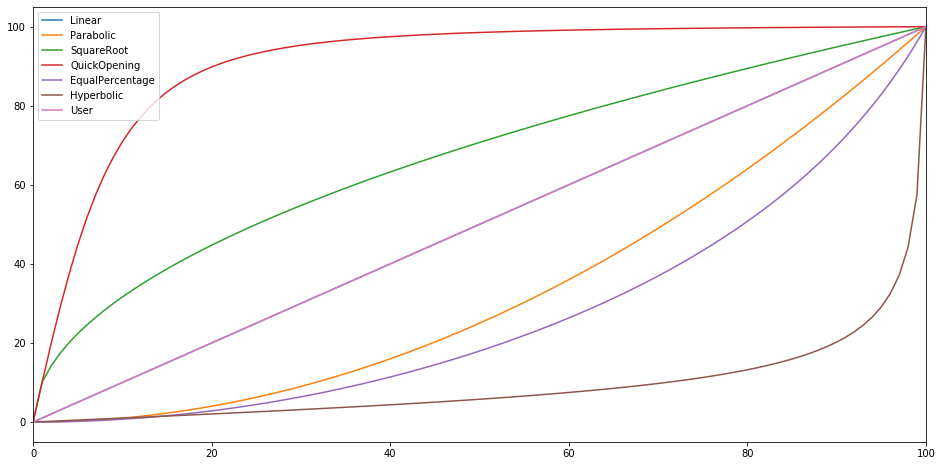

In [12]:
df_valve= pd.DataFrame(openings, index=positions)
df_valve.plot(kind='line', style='-')